In [40]:
"""
Testing the spherical compositing method for ERA5 and ACs
"""

'\nTesting the spherical compositing method for ERA5 and ACs\n'

In [2]:
%matplotlib inline

import cartopy.crs as ccrs
import copy
import matplotlib.pyplot as plt
import numpy as np
import sys
import datetime as dt
import xarray as xr

from datetime import datetime
from netCDF4 import Dataset
from IPython.display import clear_output

In [41]:
pwd

'/home/disk/sipn/rclancy/analysis/final/spherical/tests'

In [3]:
sys.path.insert(1, '/home/disk/sipn/rclancy/analysis/final/spherical/utils')

import master_utils_ERA5 as mue
import read_ERA5_utils as rera5u
from spatial_utils import (unpack_spatial_info, rhumb_np, find_in_hemisphere)

In [4]:
import importlib
#importlib.reload(mue);
#importlib.reload(sau);

In [5]:
class spatial_info:   
    # Forecast offset options in days
    # Select using t_ind. e.g. day_ind(0)=1, day_ind(6)=14;
    day_ind = ('1', '2', '3', '5', '7', '10', '14')
    
    def __init__(self, nc_file, var_name, t_ind, scale, months,
                 amp_perc, max_lat, max_d, step_size_a, step_size_d, SIC_only, nonanom, regions, change,
                 dstart, doff, ystart, yend):
        # File name(s) from which variable will be loaded
        self.nc_file = nc_file
        if isinstance(nc_file, str):
            self.nc_file = [nc_file]
        # Variable name to be loaded
        self.var_name = var_name
        # Time offset (set as False if not doing a forecast)
        self.t_ind = t_ind
        # Scale anomalies by climatology standard deviation if True, else False
        self.scale = scale
        # Select which months to include
        self.months = months
        # Amplitude fraction. The upper amp_perc percentage of amplitudes is used.
        self.amp_perc = amp_perc
        # Maximum latitude. Above this variable ignored.
        self.max_lat = max_lat
        # Maximum distance (km). Beyond this radius variable ignored/
        self.max_d = max_d
        # Resolution (degrees) of grid on which final compositing is done.
        self.step_size_a = step_size_a
        # Resolution (km) of grid on which final compositing is done.
        self.step_size_d = step_size_d
        # Getting date name
        self.var_date_name = var_name + '_dates'
        # Setting if only want to analyse over sea ice
        self.SIC_only = SIC_only
        # For if want to look at variable before removing climatology
        self.nonanom = nonanom
        # Set region of interest...
        self.regions = regions
        # True/False if doing change of variable from dstart to doff
        self.change = change
        # If change==True, give start date for change (0 for from TPV/AC, -1 for one day before, etc)
        self.dstart = dstart
        # If change==True, gives end date for change (0 for to TPV/AC, 1 for one day after, etc)
        # If change==False, gives day offset from TPV/AC to analyse. set to 0 for day of TPV/AC.
        self.doff = doff
        # First year of TPVs/ACs to investigate
        self.ystart = ystart
        # Last year of TPVs/ACs to investigate (inclusive)
        self.yend = yend

In [6]:
def get_nc_files_ERA5(months, lstr1, lstr2):
    """
    Gets list of netcdf files to be loaded for ERA5 data
    Buffers so load one month before and after month of interest in case we need days before/after system
    lstr1 and lstr2 are the bit before and after months get filled in in load string 
    """
    mstr = []
    nc_file = []
    if months[0] == 1:
            mstr.append(str(12).zfill(2))
    else:
        mstr.append(str(months[0]-1).zfill(2))

    for m in months:
        mstr.append(str(m).zfill(2))

    if months[-1] == 12:
        mstr.append(str(1).zfill(2))
    else:
        mstr.append(str(months[-1]+1).zfill(2))    

    for i, m in enumerate(mstr):
        nc_file.append(lstr1 + m + lstr2)
        
    return(nc_file)

In [7]:
# Inputs: AC PSL JJA
file_name, var_grid_m, grid_count_m = [], [], []
sys_type = 'AC'
var_name = 'PSL'
t_ind = False
scale = False
months = [6, 7, 8]
amp_perc = 25
max_lat = 90
max_d = 1500
step_size_d = 50 #10 #100
step_size_a = 10 #5 #20
SIC_only = False
nonanom = False
regions = 'all'
change = False
dstart = 0
doff = 0
ystart = 2000
yend = 2016

lstr1 = '/home/disk/sipn/rclancy/ERA5/anomalies/mean_sea_level_pressure/anom_months='
lstr2 = '_years=2000to2016_minlat=60_grid=0.25x0.25.nc'
nc_file = get_nc_files_ERA5(months, lstr1, lstr2)

In [8]:
info = spatial_info(nc_file, var_name, t_ind, scale, months, amp_perc, max_lat, max_d, step_size_a,
                    step_size_d, SIC_only, nonanom, regions, change, dstart, doff, ystart, yend)

## var_grid_all, grid_count_all, a_im, d_im = mue.spherical_composite_ERA5_AC(info)

In [9]:
# Unpack input class
(nc_file, var_name, var_date_name, t_ind, scale, months, amp_perc, max_lat, max_d, step_size_a,
 step_size_d, SIC_only, nonanom, regions, change, dstart, doff, ystart, yend) = unpack_spatial_info(info)

In [10]:
# Expanding out this function:
# Read ERA5 data
# var_anom = rera5u.read_ERA5_var(nc_file, nonanom)

months = [6, 7, 8]
nonanom = False

var_anom = []
for nc_count, nc in enumerate(nc_file):
    print(nc)
    fh = Dataset(nc, mode='r')
    A = list(fh.variables.keys())
    v1 = [x for x in A if "_anom" in x]
    v2 = [x for x in A if "_clim" in x]
    var_anom_sub = fh.variables[v1[0]][:]
    print('Shape var_anom_sub:', var_anom_sub.shape)

    var_anom.append(var_anom_sub)

    var_anom[nc_count] = np.transpose(var_anom[nc_count], (1, 2, 0))

var_anom = np.dstack(var_anom)
var_anom = var_anom.data
print('Size: ', var_anom.shape)

var_clim, var_anom_sub = [], []

/home/disk/sipn/rclancy/ERA5/anomalies/mean_sea_level_pressure/anom_months=05_years=2000to2016_minlat=60_grid=0.25x0.25.nc
Shape var_anom_sub: (2108, 121, 1440)
/home/disk/sipn/rclancy/ERA5/anomalies/mean_sea_level_pressure/anom_months=06_years=2000to2016_minlat=60_grid=0.25x0.25.nc
Shape var_anom_sub: (2040, 121, 1440)
/home/disk/sipn/rclancy/ERA5/anomalies/mean_sea_level_pressure/anom_months=07_years=2000to2016_minlat=60_grid=0.25x0.25.nc
Shape var_anom_sub: (2108, 121, 1440)
/home/disk/sipn/rclancy/ERA5/anomalies/mean_sea_level_pressure/anom_months=08_years=2000to2016_minlat=60_grid=0.25x0.25.nc
Shape var_anom_sub: (2108, 121, 1440)
/home/disk/sipn/rclancy/ERA5/anomalies/mean_sea_level_pressure/anom_months=09_years=2000to2016_minlat=60_grid=0.25x0.25.nc
Shape var_anom_sub: (2040, 121, 1440)
Size:  (121, 1440, 10404)


In [11]:
# Read ERA5 data (expanded out in above cell)
# var_anom = rera5u.read_ERA5_var(nc_file, nonanom)

# Get dates/times
var_year, var_month, var_day, var_hour = rera5u.get_ERA5_dates(nc_file)
print('Size var_year:', var_year.shape)

# Sort dates/times
var_anom, var_year, var_month, var_day, var_hour = rera5u.sort_ERA5_dates(
                                                   var_anom, var_year, var_month, var_day, var_hour)
print('Size var_anom:', var_anom.shape)
print('Size var_year:', var_year.shape)

# Get lat/lon coords
latitude_ERA5, longitude_ERA5, latmesh_ERA5, lonmesh_ERA5 = rera5u.get_ERA5_lat_lon(nc_file)
print('Size latmesh_ERA5:', latmesh_ERA5.shape)
print('Size lonmesh_ERA5:', latmesh_ERA5.shape)

Size var_year: (10404,)
Size var_anom: (121, 1440, 10404)
Size var_year: (10404,)
latitude_ERA5:  (121,)
longitude_ERA5:  (1440,)
Size latmesh_ERA5: (121, 1440)
Size lonmesh_ERA5: (121, 1440)


In [13]:
# Select just anomalies in specified months
var_anom, var_year, var_month, var_day, var_hour = rera5u.select_ERA5_months(
                                                   var_anom, var_year, var_month, var_day, var_hour, months)

In [14]:
# Get date variable for ERA5
var_dates = rera5u.make_var_dates(var_year, var_month, var_day, var_hour)

In [15]:
# Load AC data (Cyclones: 1958 to 2016 inclusive)
data_dir = '/home/disk/sipn/rclancy/analysis/latest/input_data/'
all_cyclones = np.loadtxt(data_dir + 'all_cyclones_matched_all_seasons')
colnames_ACs = open(data_dir + 'colnames_ACs.ascii').read().split()

# Select just ACs north of 65N from ystart to yend, from specified months
AC_year = all_cyclones[:,2]
AC_month = all_cyclones[:,3]
AC_latitude = all_cyclones[:,13]
select_dates = np.isin(AC_month, months) & np.isin(AC_year, list(range(ystart, yend+1))) & (AC_latitude>65)
print(all_cyclones.shape)
all_cyclones = all_cyclones[select_dates,:] 
print(all_cyclones.shape)

(1018860, 27)
(14438, 27)


In [16]:
# Select just ACs above a given laplacian fraction
amp_sub = all_cyclones[:,10]
amp_co = np.percentile(amp_sub, 100-amp_perc)
print(all_cyclones.shape)
all_cyclones= all_cyclones[amp_sub>=amp_co,:]  
amp_sub = all_cyclones[:,10]
print(all_cyclones.shape)

(14438, 27)
(3615, 27)


### For each system regrid to spherical system centered domain   
#### var_grid_all, grid_count_all, a_il, a_iu, d_il, d_iu = regrid_spherical(info, all_cyclones, var_anom, var_dates,
#### ----------------------------------------------------------------------------latmesh_ERA5, lonmesh_ERA5, 'AC', 'ERA5')

In [18]:
all_systems = all_cyclones

sys_year = all_systems[:,2]
sys_month = all_systems[:,3]
sys_day = all_systems[:,4]
sys_hour = all_systems[:,5]
sys_latitude = all_systems[:,13]
sys_longitude = all_systems[:,14]    

In [19]:
# Get dates/time
var_source = 'ERA5'
var_year = var_dates[0,:]
var_month = var_dates[1,:]
var_day = var_dates[2,:]
if var_source == 'ERA5':
    var_hour = var_dates[3,:]

In [20]:
# Create interp grid
a_il = np.arange(0, 361 - step_size_a, step_size_a)
a_iu = a_il + step_size_a
d_il = np.arange(0, max_d+1 - step_size_d, step_size_d)
d_iu = d_il + step_size_d 

In [21]:
# Set up variables to collect spherical regriddings
var_grid_all = []
grid_count_all = []

In [22]:
######## Test individual regridding ##########
i = 1000

sys_latitude_sub = sys_latitude[i]
sys_longitude_sub = sys_longitude[i]

var_ind = (var_year==sys_year[i]) & (var_month==sys_month[i]) & (var_day==sys_day[i]) & (var_hour==sys_hour[i])

if sum(var_ind) < 1:
    print('No data:', sys_year[i], sys_month[i], sys_day[i], sys_hour[i])
    
# Getting var_anom for that date
var_anom_sub = np.squeeze(var_anom[:,:,var_ind])
print('var_anom_sub:', var_anom_sub.shape)

# Getting distances in km and bearing to every grid cell
distances, bearing = rhumb_np(sys_longitude_sub, sys_latitude_sub, lonmesh_ERA5, latmesh_ERA5)

var_anom_sub: (121, 1440)


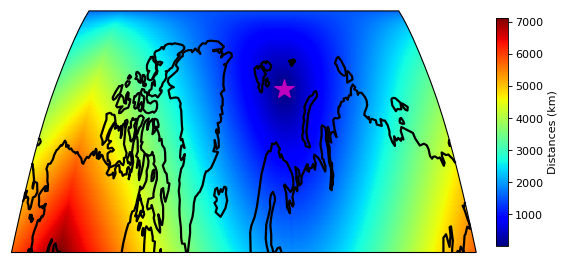

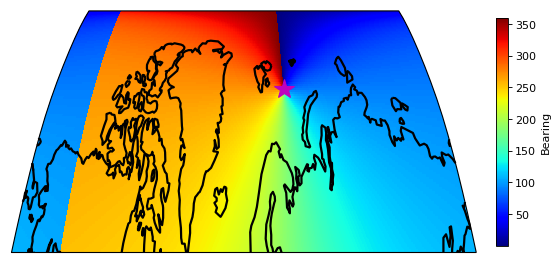

In [24]:
# Test plot of distances
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, distances, transform = ccrs.PlateCarree(),cmap='jet')
plt.colorbar(fraction=0.023, pad=0.04, label = 'Distances (km)')
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

# Test plot of bearing
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, bearing, transform = ccrs.PlateCarree(),cmap='jet')
plt.colorbar(fraction=0.023, pad=0.04, label = 'Bearing')
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

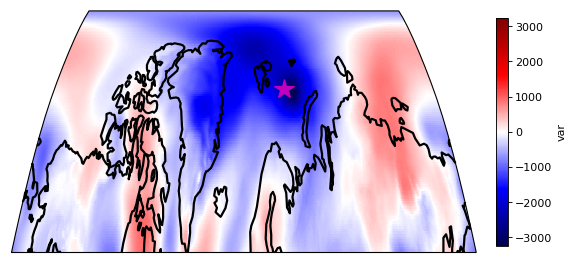

In [25]:
# Original plot of anoms before regridding
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, var_anom_sub, transform = ccrs.PlateCarree(),cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04, label = 'var')
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

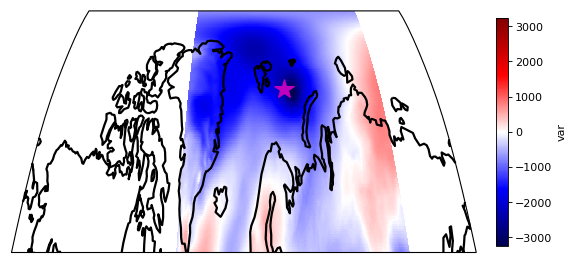

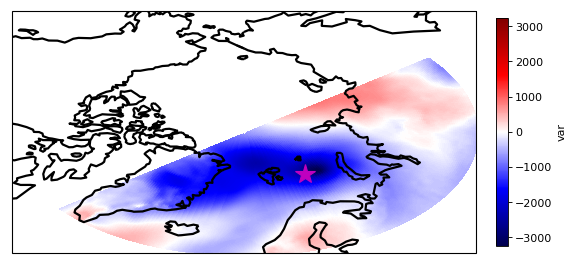

In [26]:
# Setting to nan points in different hemisphere (meridionally)
in_hemis = find_in_hemisphere(sys_longitude_sub, lonmesh_ERA5)
var_anom_sub[in_hemis!=1] = np.nan

# Test plot of var_anom before regridding
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, var_anom_sub, transform = ccrs.PlateCarree(),cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04, label = 'var')
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

# Test plot of var_anom before regridding
fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, var_anom_sub, transform = ccrs.PlateCarree(),cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04, label = 'var')
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

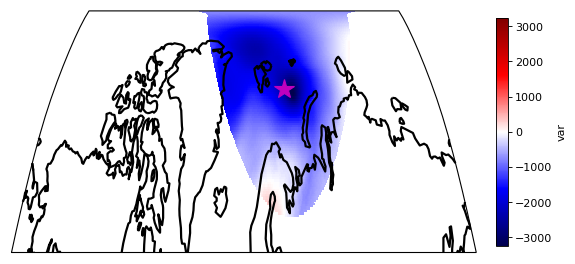

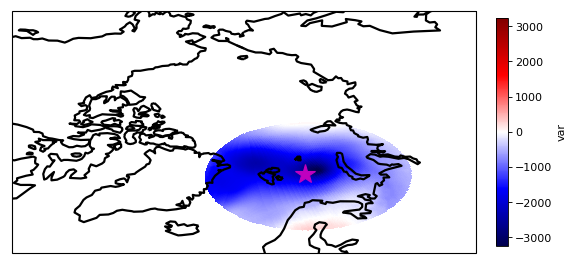

In [27]:
# Setting to nan points outside of max_d of system
var_anom_sub[distances>=max_d] = np.nan

fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, var_anom_sub, transform = ccrs.PlateCarree(),cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04, label = 'var')
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

fig=plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(linewidth=2)
plt.pcolormesh(longitude_ERA5, latitude_ERA5, var_anom_sub, transform = ccrs.PlateCarree(),cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04, label = 'var')
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(sys_longitude_sub, sys_latitude_sub, '*m', markersize=18, transform = ccrs.PlateCarree())

In [28]:
# Flatten
distances = np.ndarray.flatten(distances)
bearing = np.ndarray.flatten(bearing)
var_anom_sub = np.ndarray.flatten(var_anom_sub)

# Select only non-nan values
distances = distances[np.isfinite(var_anom_sub)]
bearing = bearing[np.isfinite(var_anom_sub)]
var_anom_sub = var_anom_sub[np.isfinite(var_anom_sub)]

In [29]:
var_grid = np.zeros([a_il.size, d_il.size])
grid_count = np.zeros([a_il.size, d_il.size])

for i in range(0, a_il.size):
    for j in range(0, d_il.size):
        cond_1 = bearing>a_il[i]
        cond_2 = bearing<a_iu[i]
        cond_3 = distances>d_il[j]
        cond_4 = distances<d_iu[j]

        grid_ind = (np.column_stack((cond_1, cond_2, cond_3, cond_4)).all(axis=1))
        grid_count[i,j] = np.count_nonzero(grid_ind)
        var_grid_sub = var_anom_sub[grid_ind]
        var_grid[i,j] = np.nanmean(var_grid_sub, dtype=np.float64) 
        #dtype=np.float64 is important for accuracy if using float32 or float16 as inputs

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


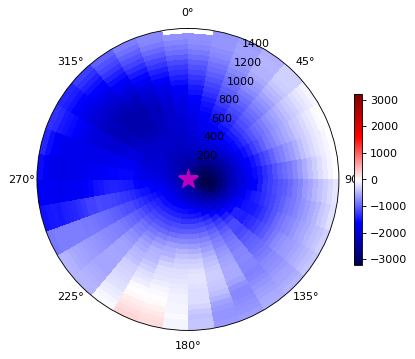

In [30]:
# How does it look once regridded
# Note that distortion in various projections means can sometimes look a little weird, but still decent)
# Further testing of regridding process shows everything is working as it should.
r, th = np.meshgrid(np.arange(0,max_d+1,step_size_d), np.radians(np.arange(0,361,step_size_a)))    
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.pcolormesh(th, r, var_grid, cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04)
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(0, 0, '*m', markersize=18)

In [31]:
##### Test for all ACs ########

var_grid_all = []
grid_count_all = []

# Create interp grid
step_size_a = 20
step_size_d = 200

a_il = np.arange(0, 361 - step_size_a, step_size_a)
a_iu = a_il + step_size_a
d_il = np.arange(0, max_d+1 - step_size_d, step_size_d)
d_iu = d_il + step_size_d 

max_count = len(sys_year)
for i in range(0, len(sys_year)):
    print(i, 'out of', max_count)

    if sys_year[i] < np.min(var_year):
        continue

    sys_latitude_sub = sys_latitude[i]
    sys_longitude_sub = sys_longitude[i]

    # Find index of matching variable dates
    if var_source == 'ERA5':
        var_ind = (var_year==sys_year[i]) & (var_month==sys_month[i]) & (var_day==sys_day[i]) & (var_hour==sys_hour[i])
    else:
        var_ind = (var_year==sys_year[i]) & (var_month==sys_month[i]) & (var_day==sys_day[i])

    if sum(var_ind) < 1:
        if var_source == 'ERA5':
            print('No data:', sys_year[i], sys_month[i], sys_day[i], sys_hour[i])
        else:
            print('No data:', sys_year[i], sys_month[i], sys_day[i])
        continue

    # Getting var_anom for that date
    var_anom_sub = np.squeeze(var_anom[:,:,var_ind])

    # Getting distances in km and bearing to every grid cell
    distances, bearing = rhumb_np(sys_longitude_sub, sys_latitude_sub, lonmesh_ERA5, latmesh_ERA5)

    # Setting to nan points in different hemisphere (meridionally)
    in_hemis = find_in_hemisphere(sys_longitude_sub, lonmesh_ERA5)
    var_anom_sub[in_hemis!=1] = np.nan

    # Setting to nan points outside of max_d of system
    var_anom_sub[distances>=max_d] = np.nan

    # Flatten
    distances = np.ndarray.flatten(distances)
    bearing = np.ndarray.flatten(bearing)
    var_anom_sub = np.ndarray.flatten(var_anom_sub)

    # Select only non-nan values
    distances = distances[np.isfinite(var_anom_sub)]
    bearing = bearing[np.isfinite(var_anom_sub)]
    var_anom_sub = var_anom_sub[np.isfinite(var_anom_sub)]

    var_grid = np.zeros([a_il.size, d_il.size])
    grid_count = np.zeros([a_il.size, d_il.size])

    for i in range(0, a_il.size):
        for j in range(0, d_il.size):
            cond_1 = bearing>a_il[i]
            cond_2 = bearing<a_iu[i]
            cond_3 = distances>d_il[j]
            cond_4 = distances<d_iu[j]

            grid_ind = (np.column_stack((cond_1, cond_2, cond_3, cond_4)).all(axis=1))
            grid_count[i,j] = np.count_nonzero(grid_ind)
            var_grid_sub = var_anom_sub[grid_ind]
            var_grid[i,j] = np.nanmean(var_grid_sub, dtype=np.float64) 
            #dtype=np.float64 is important for accuracy if using float32 or float16 as inputs

    var_grid_all.append(var_grid)
    grid_count_all.append(grid_count)

0 out of 3615


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice


1 out of 3615
2 out of 3615
3 out of 3615
4 out of 3615
5 out of 3615
6 out of 3615
7 out of 3615
8 out of 3615
9 out of 3615
10 out of 3615
11 out of 3615
12 out of 3615
13 out of 3615
14 out of 3615
15 out of 3615
16 out of 3615
17 out of 3615
18 out of 3615
19 out of 3615
20 out of 3615
21 out of 3615
22 out of 3615
23 out of 3615
24 out of 3615
25 out of 3615
26 out of 3615
27 out of 3615
28 out of 3615
29 out of 3615
30 out of 3615
31 out of 3615
32 out of 3615
33 out of 3615
34 out of 3615
35 out of 3615
36 out of 3615
37 out of 3615
38 out of 3615
39 out of 3615
40 out of 3615
41 out of 3615
42 out of 3615
43 out of 3615
44 out of 3615
45 out of 3615
46 out of 3615
47 out of 3615
48 out of 3615
49 out of 3615
50 out of 3615
51 out of 3615
52 out of 3615
53 out of 3615
54 out of 3615
55 out of 3615
56 out of 3615
57 out of 3615
58 out of 3615
59 out of 3615
60 out of 3615
61 out of 3615
62 out of 3615
63 out of 3615
64 out of 3615
65 out of 3615
66 out of 3615
67 out of 3615
68 o

520 out of 3615
521 out of 3615
522 out of 3615
523 out of 3615
524 out of 3615
525 out of 3615
526 out of 3615
527 out of 3615
528 out of 3615
529 out of 3615
530 out of 3615
531 out of 3615
532 out of 3615
533 out of 3615
534 out of 3615
535 out of 3615
536 out of 3615
537 out of 3615
538 out of 3615
539 out of 3615
540 out of 3615
541 out of 3615
542 out of 3615
543 out of 3615
544 out of 3615
545 out of 3615
546 out of 3615
547 out of 3615
548 out of 3615
549 out of 3615
550 out of 3615
551 out of 3615
552 out of 3615
553 out of 3615
554 out of 3615
555 out of 3615
556 out of 3615
557 out of 3615
558 out of 3615
559 out of 3615
560 out of 3615
561 out of 3615
562 out of 3615
563 out of 3615
564 out of 3615
565 out of 3615
566 out of 3615
567 out of 3615
568 out of 3615
569 out of 3615
570 out of 3615
571 out of 3615
572 out of 3615
573 out of 3615
574 out of 3615
575 out of 3615
576 out of 3615
577 out of 3615
578 out of 3615
579 out of 3615
580 out of 3615
581 out of 3615
582 out 

1031 out of 3615
1032 out of 3615
1033 out of 3615
1034 out of 3615
1035 out of 3615
1036 out of 3615
1037 out of 3615
1038 out of 3615
1039 out of 3615
1040 out of 3615
1041 out of 3615
1042 out of 3615
1043 out of 3615
1044 out of 3615
1045 out of 3615
1046 out of 3615
1047 out of 3615
1048 out of 3615
1049 out of 3615
1050 out of 3615
1051 out of 3615
1052 out of 3615
1053 out of 3615
1054 out of 3615
1055 out of 3615
1056 out of 3615
1057 out of 3615
1058 out of 3615
1059 out of 3615
1060 out of 3615
1061 out of 3615
1062 out of 3615
1063 out of 3615
1064 out of 3615
1065 out of 3615
1066 out of 3615
1067 out of 3615
1068 out of 3615
1069 out of 3615
1070 out of 3615
1071 out of 3615
1072 out of 3615
1073 out of 3615
1074 out of 3615
1075 out of 3615
1076 out of 3615
1077 out of 3615
1078 out of 3615
1079 out of 3615
1080 out of 3615
1081 out of 3615
1082 out of 3615
1083 out of 3615
1084 out of 3615
1085 out of 3615
1086 out of 3615
1087 out of 3615
1088 out of 3615
1089 out of 36

1513 out of 3615
1514 out of 3615
1515 out of 3615
1516 out of 3615
1517 out of 3615
1518 out of 3615
1519 out of 3615
1520 out of 3615
1521 out of 3615
1522 out of 3615
1523 out of 3615
1524 out of 3615
1525 out of 3615
1526 out of 3615
1527 out of 3615
1528 out of 3615
1529 out of 3615
1530 out of 3615
1531 out of 3615
1532 out of 3615
1533 out of 3615
1534 out of 3615
1535 out of 3615
1536 out of 3615
1537 out of 3615
1538 out of 3615
1539 out of 3615
1540 out of 3615
1541 out of 3615
1542 out of 3615
1543 out of 3615
1544 out of 3615
1545 out of 3615
1546 out of 3615
1547 out of 3615
1548 out of 3615
1549 out of 3615
1550 out of 3615
1551 out of 3615
1552 out of 3615
1553 out of 3615
1554 out of 3615
1555 out of 3615
1556 out of 3615
1557 out of 3615
1558 out of 3615
1559 out of 3615
1560 out of 3615
1561 out of 3615
1562 out of 3615
1563 out of 3615
1564 out of 3615
1565 out of 3615
1566 out of 3615
1567 out of 3615
1568 out of 3615
1569 out of 3615
1570 out of 3615
1571 out of 36

1995 out of 3615
1996 out of 3615
1997 out of 3615
1998 out of 3615
1999 out of 3615
2000 out of 3615
2001 out of 3615
2002 out of 3615
2003 out of 3615
2004 out of 3615
2005 out of 3615
2006 out of 3615
2007 out of 3615
2008 out of 3615
2009 out of 3615
2010 out of 3615
2011 out of 3615
2012 out of 3615
2013 out of 3615
2014 out of 3615
2015 out of 3615
2016 out of 3615
2017 out of 3615
2018 out of 3615
2019 out of 3615
2020 out of 3615
2021 out of 3615
2022 out of 3615
2023 out of 3615
2024 out of 3615
2025 out of 3615
2026 out of 3615
2027 out of 3615
2028 out of 3615
2029 out of 3615
2030 out of 3615
2031 out of 3615
2032 out of 3615
2033 out of 3615
2034 out of 3615
2035 out of 3615
2036 out of 3615
2037 out of 3615
2038 out of 3615
2039 out of 3615
2040 out of 3615
2041 out of 3615
2042 out of 3615
2043 out of 3615
2044 out of 3615
2045 out of 3615
2046 out of 3615
2047 out of 3615
2048 out of 3615
2049 out of 3615
2050 out of 3615
2051 out of 3615
2052 out of 3615
2053 out of 36

2477 out of 3615
2478 out of 3615
2479 out of 3615
2480 out of 3615
2481 out of 3615
2482 out of 3615
2483 out of 3615
2484 out of 3615
2485 out of 3615
2486 out of 3615
2487 out of 3615
2488 out of 3615
2489 out of 3615
2490 out of 3615
2491 out of 3615
2492 out of 3615
2493 out of 3615
2494 out of 3615
2495 out of 3615
2496 out of 3615
2497 out of 3615
2498 out of 3615
2499 out of 3615
2500 out of 3615
2501 out of 3615
2502 out of 3615
2503 out of 3615
2504 out of 3615
2505 out of 3615
2506 out of 3615
2507 out of 3615
2508 out of 3615
2509 out of 3615
2510 out of 3615
2511 out of 3615
2512 out of 3615
2513 out of 3615
2514 out of 3615
2515 out of 3615
2516 out of 3615
2517 out of 3615
2518 out of 3615
2519 out of 3615
2520 out of 3615
2521 out of 3615
2522 out of 3615
2523 out of 3615
2524 out of 3615
2525 out of 3615
2526 out of 3615
2527 out of 3615
2528 out of 3615
2529 out of 3615
2530 out of 3615
2531 out of 3615
2532 out of 3615
2533 out of 3615
2534 out of 3615
2535 out of 36

2959 out of 3615
2960 out of 3615
2961 out of 3615
2962 out of 3615
2963 out of 3615
2964 out of 3615
2965 out of 3615
2966 out of 3615
2967 out of 3615
2968 out of 3615
2969 out of 3615
2970 out of 3615
2971 out of 3615
2972 out of 3615
2973 out of 3615
2974 out of 3615
2975 out of 3615
2976 out of 3615
2977 out of 3615
2978 out of 3615
2979 out of 3615
2980 out of 3615
2981 out of 3615
2982 out of 3615
2983 out of 3615
2984 out of 3615
2985 out of 3615
2986 out of 3615
2987 out of 3615
2988 out of 3615
2989 out of 3615
2990 out of 3615
2991 out of 3615
2992 out of 3615
2993 out of 3615
2994 out of 3615
2995 out of 3615
2996 out of 3615
2997 out of 3615
2998 out of 3615
2999 out of 3615
3000 out of 3615
3001 out of 3615
3002 out of 3615
3003 out of 3615
3004 out of 3615
3005 out of 3615
3006 out of 3615
3007 out of 3615
3008 out of 3615
3009 out of 3615
3010 out of 3615
3011 out of 3615
3012 out of 3615
3013 out of 3615
3014 out of 3615
3015 out of 3615
3016 out of 3615
3017 out of 36

3441 out of 3615
3442 out of 3615
3443 out of 3615
3444 out of 3615
3445 out of 3615
3446 out of 3615
3447 out of 3615
3448 out of 3615
3449 out of 3615
3450 out of 3615
3451 out of 3615
3452 out of 3615
3453 out of 3615
3454 out of 3615
3455 out of 3615
3456 out of 3615
3457 out of 3615
3458 out of 3615
3459 out of 3615
3460 out of 3615
3461 out of 3615
3462 out of 3615
3463 out of 3615
3464 out of 3615
3465 out of 3615
3466 out of 3615
3467 out of 3615
3468 out of 3615
3469 out of 3615
3470 out of 3615
3471 out of 3615
3472 out of 3615
3473 out of 3615
3474 out of 3615
3475 out of 3615
3476 out of 3615
3477 out of 3615
3478 out of 3615
3479 out of 3615
3480 out of 3615
3481 out of 3615
3482 out of 3615
3483 out of 3615
3484 out of 3615
3485 out of 3615
3486 out of 3615
3487 out of 3615
3488 out of 3615
3489 out of 3615
3490 out of 3615
3491 out of 3615
3492 out of 3615
3493 out of 3615
3494 out of 3615
3495 out of 3615
3496 out of 3615
3497 out of 3615
3498 out of 3615
3499 out of 36

In [32]:
# Turn list of individual regriddings into array
var_grid_all = np.dstack(var_grid_all)
grid_count_all = np.dstack(grid_count_all)

In [33]:
# Composite along array
var_grid = np.nanmean(var_grid_all,2)
grid_count = np.nansum(np.sign(grid_count_all),2)

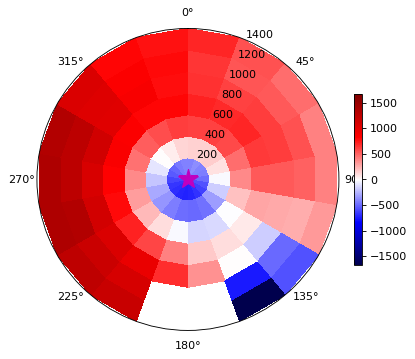

In [34]:
# Check out individual regriddings here by changing var_ind
var_ind = 304

r, th = np.meshgrid(np.arange(0,max_d+1,step_size_d), np.radians(np.arange(0,361,step_size_a)))    
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.pcolormesh(th, r, var_grid_all[:,:,var_ind], cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04)
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(0, 0, '*m', markersize=18)

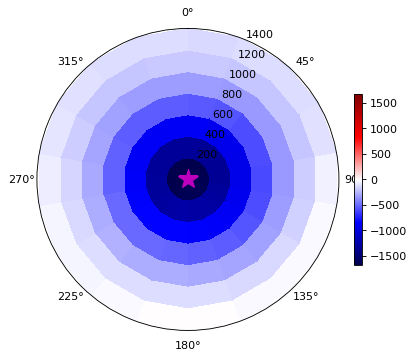

In [35]:
# Check out composite
r, th = np.meshgrid(np.arange(0,max_d+1,step_size_d), np.radians(np.arange(0,361,step_size_a)))    
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.pcolormesh(th, r, var_grid, cmap='seismic')
plt.colorbar(fraction=0.023, pad=0.04)
A, B = plt.gci().get_clim()
cmax=np.abs(np.array([A, B])).max()
plt.clim(-cmax, cmax)
plt.plot(0, 0, '*m', markersize=18)

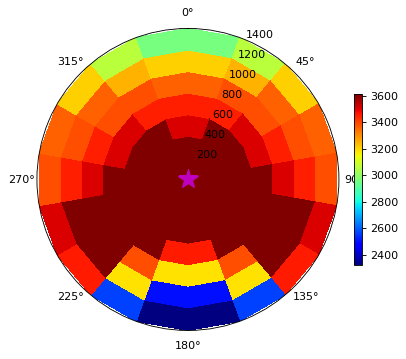

In [36]:
# Check out composite grid count
r, th = np.meshgrid(np.arange(0,max_d+1,step_size_d), np.radians(np.arange(0,361,step_size_a)))    
fig=plt.figure(figsize=(6, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.pcolormesh(th, r, grid_count, cmap='jet')
plt.colorbar(fraction=0.023, pad=0.04)
plt.plot(0, 0, '*m', markersize=18)